# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:

def simulate_BM(n_sample, dt, n_timestep):
    noise = torch.randn(size=(n_sample, n_timestep))
    paths_incr = noise * torch.sqrt(torch.tensor(dt))
    paths = torch.cumsum(paths_incr, axis=1)
    BM_paths = torch.cat([torch.zeros((n_sample, 1)), paths], axis=1)
    BM_paths = BM_paths[..., None]
    return BM_paths


def simulate_BS(n_sample, dt, n_timestep, mu, sigma):
    time_grid = torch.linspace(0, dt * n_timestep, n_timestep + 1)
    time_paths = time_grid.expand([n_sample, n_timestep + 1])[..., None]
    BM_paths = simulate_BM(n_sample, dt, n_timestep)
    BS_paths = torch.exp(sigma * BM_paths + (mu - 0.5 * sigma**2) * time_paths)
    return BS_paths


start_date = '2000-01-01'
end_date = '2010-01-01'

t = pd.date_range(start=start_date, end=end_date)
n_timestep = len(t)
df = pd.DataFrame({'Date': t, 'spx': t})
df.set_index('Date', inplace=True)
dt = 1/252
mu = 0.1
sigma = 0.2
BS_paths = simulate_BS(1, dt, n_timestep-1, mu, sigma)
path = BS_paths[0,:,0].numpy().astype(np.float64)
df['spx'] = path
df.to_csv('data/bs.csv')

df = pd.read_csv('data/spx.csv', index_col=0, parse_dates=True)
df.info()
df = pd.read_csv('data/bs.csv', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7000 entries, 1995-01-03 to 2022-10-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     7000 non-null   float64
dtypes: float64(1)
memory usage: 109.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2000-01-01 to 2010-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     3654 non-null   float64
dtypes: float64(1)
memory usage: 57.1 KB


In [4]:
# samples
batch_size = 256 # number of samples in each batch
sample_len = 61 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = True # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42


# BS
batch_size = 256 # number of samples in each batch
sample_len = 61 # length of each sample
stride = 1 


# real data parameters
# stride = 50 # for real data
# start_date = '1995-01-01' # start date for real data
# end_date = '2918-09-18' # end date for real data


In [5]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 10 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = True # feed in history for LSTM generators
hist_len = 50

In [6]:
noise_dim = 4 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 20

### Training Related

In [7]:
epochs = 10000 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.1 # starting kernel_sigma
num_losses = 20

### Save to tensorboard log

In [8]:
# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)

### Data, kernel, generator

In [9]:
dataloader = get_dataloader(**{**data_params, **model_params, 'bs':True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5170.2677931699145
            Iterations: 26
            Function evaluations: 602
            Gradient evaluations: 26
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5170.27
Distribution:                  Normal   AIC:                           10382.5
Method:            Maximum Likelihood   BIC:                           10512.8
                                        No. Observations:                 3653
Date:                Sun, Sep 01 2024   Df Residuals:                     3653
Time:                        15:09:36   Df Model:                            0
                               Volatility Model                              


GenLSTM(
  (rnn): LSTM(6, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

2
torch.Size([256, 61, 2])
torch.Size([256, 60, 4])


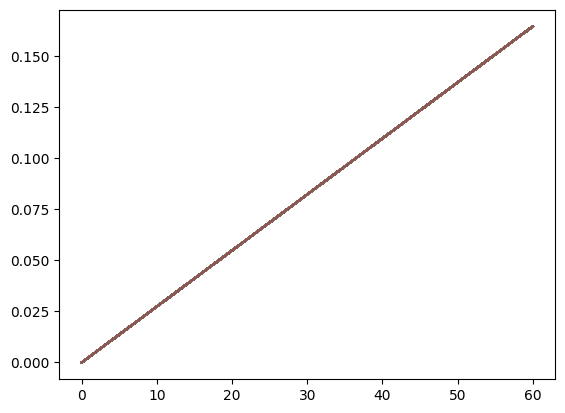

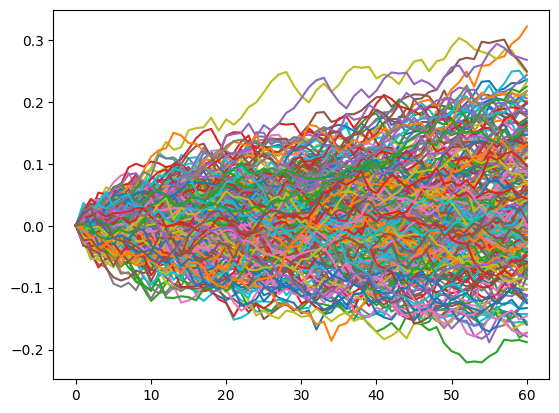

In [10]:
for item in dataloader:
    print(len(item))
    print(item[0].shape)
    print(item[1].shape)
    break
plt.plot(item[0][:,:,0].T)
plt.show()
plt.plot(item[0][:,:,1].T)
plt.show()

# Train MMD-GAN

In [11]:
train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

/Users/hous/Github/Generative-Model-Signature-MMD/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 0, loss: 3.748546655361469, avg_last_20_loss: 3.748546655361469
Saving model at epoch 0


100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Epoch 1, loss: 0.9232554068932166, avg_last_20_loss: 2.3359010311273427
Saving model at epoch 1


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 2, loss: 0.5929967440091647, avg_last_20_loss: 1.7549329354212835
Saving model at epoch 2


100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Epoch 3, loss: 0.2923449186178354, avg_last_20_loss: 1.3892859312204213
Saving model at epoch 3


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Epoch 4, loss: 0.10688974307133602, avg_last_20_loss: 1.1328066935906043
Saving model at epoch 4


100%|██████████| 13/13 [00:28<00:00,  2.16s/it]


Epoch 5, loss: 0.03155704645010141, avg_last_20_loss: 0.9492650857338538
Saving model at epoch 5


100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 6, loss: 0.008602123994093675, avg_last_20_loss: 0.8148846626281738
Saving model at epoch 6


100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


Epoch 7, loss: 0.0018451947432297927, avg_last_20_loss: 0.7132547291425557
Saving model at epoch 7


100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 8, loss: 0.001762518515953651, avg_last_20_loss: 0.6342000390729333
Saving model at epoch 8


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 9, loss: 0.00037750831017127406, avg_last_20_loss: 0.5708177859966571
Saving model at epoch 9


100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 10, loss: -0.0007736866290752704, avg_last_20_loss: 0.5188549248488633
Saving model at epoch 10


100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 11, loss: -0.0007778497842641977, avg_last_20_loss: 0.47555219362943596
Saving model at epoch 11


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 12, loss: -0.0012192909534160907, avg_last_20_loss: 0.43887746404613964
Saving model at epoch 12


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 13, loss: -0.001384716767531175, avg_last_20_loss: 0.4074301654165917
Saving model at epoch 13


100%|██████████| 13/13 [00:26<00:00,  2.08s/it]


Epoch 14, loss: -0.0007048386793870192, avg_last_20_loss: 0.38022116514352644
Saving model at epoch 14


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 15, loss: -0.002042220189021184, avg_last_20_loss: 0.35632970356024224
Saving model at epoch 15


100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Epoch 16, loss: -0.0012581715217003455, avg_last_20_loss: 0.33529512267306916
Saving model at epoch 16


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 17, loss: -0.0017424179957463192, avg_last_20_loss: 0.316570814858135
Saving model at epoch 17


100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 18, loss: -0.001785571758563702, avg_last_20_loss: 0.2998152155625192
Saving model at epoch 18


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 19, loss: -0.0017256553356464093, avg_last_20_loss: 0.2847381720176109
Saving model at epoch 19


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 20, loss: -0.00165711916410006, avg_last_20_loss: 0.09722798329133252
Saving model at epoch 20


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 21, loss: -0.0013034527118389423, avg_last_20_loss: 0.051000040311079756
Saving model at epoch 21


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 22, loss: -0.0022239501659686747, avg_last_20_loss: 0.021239005602323092
Saving model at epoch 22


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 23, loss: -0.0017026937924898588, avg_last_20_loss: 0.00653662498180683
Saving model at epoch 23


100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 24, loss: -0.000937645251934345, avg_last_20_loss: 0.0011452555656433106
Saving model at epoch 24


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 25, loss: -0.0005556069887601412, avg_last_20_loss: -0.00046037710629976715
Saving model at epoch 25


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 26, loss: -0.0011126078092134916, avg_last_20_loss: -0.0009461136964651255
Saving model at epoch 26


100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 27, loss: -0.0017108550438514124, avg_last_20_loss: -0.0011239161858191858
Saving model at epoch 27


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 28, loss: -0.001802517817570613, avg_last_20_loss: -0.0013021680024953987
Saving model at epoch 28


100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 29, loss: -0.001941974346454327, avg_last_20_loss: -0.001418142135326679
Saving model at epoch 29


100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 30, loss: -0.0018999943366417517, avg_last_20_loss: -0.001474457520705003
Saving model at epoch 30


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 31, loss: -0.001844039330115685, avg_last_20_loss: -0.0015277669979975772
Saving model at epoch 31


100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 32, loss: -0.0020152605496920072, avg_last_20_loss: -0.001567565477811373
Saving model at epoch 32


100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 33, loss: -0.001474618911743164, avg_last_20_loss: -0.0015720605850219726
Saving model at epoch 33


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 34, loss: -0.0019696309016301082, avg_last_20_loss: -0.0016353001961341273
Saving model at epoch 34


100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 35, loss: -0.002407972629253681, avg_last_20_loss: -0.0016535878181457519
Saving model at epoch 35


100%|██████████| 13/13 [00:26<00:00,  2.08s/it]


Epoch 36, loss: -0.0021712779998779297, avg_last_20_loss: -0.001699243142054631
Saving model at epoch 36


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 37, loss: -0.0021034387441781852, avg_last_20_loss: -0.0017172941794762243
Saving model at epoch 37


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 38, loss: -0.00023834521953876203, avg_last_20_loss: -0.0016399328525249775


100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 39, loss: -0.002011262453519381, avg_last_20_loss: -0.001654213208418626


100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 40, loss: -0.0011958709129920374, avg_last_20_loss: -0.001631150795863225


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 41, loss: -0.0025787720313439, avg_last_20_loss: -0.001694916761838473


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 42, loss: -0.0018315682044396033, avg_last_20_loss: -0.0016752976637620192


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 43, loss: -0.0012769515697772687, avg_last_20_loss: -0.0016540105526263896


100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Epoch 44, loss: -0.0011673523829533504, avg_last_20_loss: -0.0016654959091773399


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 45, loss: -0.0020999174851637622, avg_last_20_loss: -0.0017427114339975212
Saving model at epoch 45


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 46, loss: -0.002166454608623798, avg_last_20_loss: -0.001795403773968036
Saving model at epoch 46


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 47, loss: -0.001982725583589994, avg_last_20_loss: -0.001808997300954965
Saving model at epoch 47


100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 48, loss: -0.001369182880108173, avg_last_20_loss: -0.001787330554081843


100%|██████████| 13/13 [00:37<00:00,  2.89s/it]


Epoch 49, loss: -0.0017810601454514724, avg_last_20_loss: -0.0017792848440317006


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Epoch 50, loss: -0.002115964889526367, avg_last_20_loss: -0.0017900833716759314


100%|██████████| 13/13 [07:11<00:00, 33.18s/it]


Epoch 51, loss: -0.0021006144010103666, avg_last_20_loss: -0.0018029121252206657


100%|██████████| 13/13 [00:30<00:00,  2.36s/it]


Epoch 52, loss: -0.0010088590475229116, avg_last_20_loss: -0.0017525920501122107


100%|██████████| 13/13 [00:31<00:00,  2.40s/it]


Epoch 53, loss: -0.0022748433626615084, avg_last_20_loss: -0.0017926032726581279


100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


Epoch 54, loss: -0.001750487547654372, avg_last_20_loss: -0.0017816461049593416


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 55, loss: -0.001955014008742112, avg_last_20_loss: -0.0017589981739337627


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 56, loss: -0.0021135807037353516, avg_last_20_loss: -0.0017561133091266337


100%|██████████| 13/13 [00:26<00:00,  2.08s/it]


Epoch 57, loss: -0.002041266514704778, avg_last_20_loss: -0.0017530046976529635


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 58, loss: -0.0010865651644193209, avg_last_20_loss: -0.0017954156948969916


100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Epoch 59, loss: -0.0009257610027606671, avg_last_20_loss: -0.0017411406223590557


100%|██████████| 13/13 [00:26<00:00,  2.05s/it]


Epoch 60, loss: -0.002151379218468299, avg_last_20_loss: -0.0017889160376328688


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 61, loss: -0.0012061412517841046, avg_last_20_loss: -0.001720284498654879


100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 62, loss: -0.0012943011063795823, avg_last_20_loss: -0.0016934211437518779


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 63, loss: -0.0016297377072847807, avg_last_20_loss: -0.0017110604506272535


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 64, loss: -0.0018131916339580829, avg_last_20_loss: -0.0017433524131774901


100%|██████████| 13/13 [00:29<00:00,  2.23s/it]


Epoch 65, loss: -0.0014156194833608775, avg_last_20_loss: -0.0017091375130873464


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 66, loss: -0.0007895873143122747, avg_last_20_loss: -0.0016402941483717698


100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 67, loss: -0.001117541239811824, avg_last_20_loss: -0.0015970349311828613


100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Epoch 68, loss: 0.0003660091987022987, avg_last_20_loss: -0.0015102753272423378


100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Epoch 69, loss: -0.00010743507972130409, avg_last_20_loss: -0.0014265940739558295


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 70, loss: -0.0007319817176231971, avg_last_20_loss: -0.0013573949153606708


100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Epoch 71, loss: -0.0013398757347693811, avg_last_20_loss: -0.0013193579820486216


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 72, loss: -0.0008289080399733323, avg_last_20_loss: -0.0013103604316711428


100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 73, loss: -0.0012213450211745042, avg_last_20_loss: -0.0012576855145967924


100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Epoch 74, loss: -0.0009546096508319562, avg_last_20_loss: -0.0012178916197556717


100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 75, loss: -0.002077451119056115, avg_last_20_loss: -0.001224013475271372


100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 76, loss: -0.001970016039334811, avg_last_20_loss: -0.0012168352420513448


100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 77, loss: -0.0022978782653808594, avg_last_20_loss: -0.0012296658295851489


100%|██████████| 13/13 [00:28<00:00,  2.17s/it]


Epoch 78, loss: -0.0021563309889573315, avg_last_20_loss: -0.001283154120812049


100%|██████████| 13/13 [00:28<00:00,  2.16s/it]


Epoch 79, loss: -0.001132506590623122, avg_last_20_loss: -0.001293491400205172


100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 80, loss: -0.0015172041379488432, avg_last_20_loss: -0.0012617826461791993


100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


Epoch 81, loss: -0.0011975398430457483, avg_last_20_loss: -0.0012613525757422816


100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


Epoch 82, loss: -0.0017905785487248348, avg_last_20_loss: -0.0012861664478595442


100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 83, loss: -0.0011385404146634615, avg_last_20_loss: -0.001261606583228478


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 84, loss: -0.0018089551192063552, avg_last_20_loss: -0.0012613947574908915


100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 85, loss: -0.002201557159423828, avg_last_20_loss: -0.001300691641294039


100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 86, loss: -0.00034407468942495494, avg_last_20_loss: -0.001278416010049673


100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 87, loss: -0.0016715893378624548, avg_last_20_loss: -0.0013061184149522048


100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Epoch 88, loss: -0.0004990651057316706, avg_last_20_loss: -0.001349372130173903


 77%|███████▋  | 10/13 [00:22<00:06,  2.27s/it]


KeyboardInterrupt: 

In [14]:
torch.save(generator.state_dict(), f'./{writer.log_dir}/generator.pt')
# writer.flush()

In [20]:
with torch.no_grad():
    for X in tqdm(dataloader):
        if ma: # ma noise is generated for each batch within dataset class
            X, noise = X
            if noise.device != device: noise = noise.to(device)
        else: # Gaussian noise is generated for each batch
            noise = torch.tensor(rng.normal(size=(batch_size, sample_len-1, noise_dim)), device=device, dtype=dtype, requires_grad=False)
        X = X.to(device)

        t = X[:,:,:1] # time dimension of path is always first series of the last dim
        if conditional:
            hist_x = X[:,:hist_len,1:] # history portion of path
            output = generator(noise, t, hist_x=hist_x)
            output = torch.cat([t, output], axis=-1) # concatenate time and history + generated path along time series value dimension
            # remove history portion from X and output to compute MMD only on generated path
            X = X[:,hist_len:,:]
            output = output[:,hist_len:,:]
        else:
            output = generator(noise, t)
            output = torch.cat([t, output], axis=-1) # concatenate time and generated path along time series value dimension
        break


  0%|          | 0/13 [00:00<?, ?it/s]


In [21]:
output.shape

torch.Size([256, 11, 2])

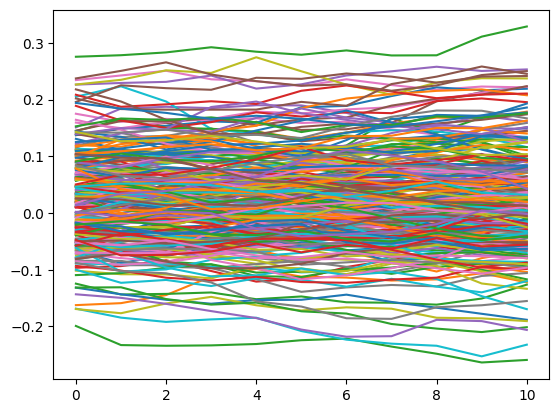

In [24]:
plt.plot(output[:,:,1].T)
plt.show()